In [1]:
import itertools
import nibabel as nib
import numpy as np
import time
import pickle

from collections import defaultdict
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from sklearn.metrics import roc_curve, auc

import sys
sys.path.append("ComputeCanada/frequency_tagging")
from utils import (
    get_roi_colour_codes,
    extract_im_products,
    get_frequency_text_codes,
    change_font,
    SCRATCH_DIR,
)
sys.path.append("/opt/app/scripts")
from im_sc_utils import (
    get_binary_paths,
    convert_multimap_to_fo_maps,
    process_maps,
    compute_metrics,
    generate_surrogates,
    convert_array_to_top_n_values,
    compute_metrics_over_surrogates,
    contains_only_0_1,
    area_under_curve,
    add_data_to_dict,
    N_VERTICES_AFTER_RESAMPLING,
    GEODESIC_LH,
    GEODESIC_RH,
    DSCALAR_TEMPLATE,
)
change_font()

# Directories
surrogatedir = SCRATCH_DIR / "surrogate_maps"
if not surrogatedir.exists():
    surrogatedir.mkdir(exist_ok=True, parents=True)
pickledir = surrogatedir / "pickles"
if not pickledir.exists():
    pickledir.mkdir(exist_ok=True, parents=True)
null_auc_dir = surrogatedir / "null_auc"
if not null_auc_dir.exists():
    null_auc_dir.mkdir(parents=True, exist_ok=True)


Run surrogate map generation and metric calculation over all surrogate maps

In [2]:
CONTAINER = '/project/def-mmur/gngo4/containers/neuroimaging-notebook-v2.simg'
main_scripts_dir = Path("/data/scripts/04_im_sc")

experiment_id = "1_frequency_tagging"
mri_id = "3T"
sub_ids = ["000","002","003","004","006","005","007","008","009"] # First 5 and last 4 are stimulated right visual field and left visual field, respectively
roi_task_ids = ["control","entrain"]
f1, f2 = (.125, .2)
corr_types = ["uncp","fdrp"]
constant_fo = .8
fo_spacing = .05
N_SURROGATES = 1000
for sub_id, roi_task_id, corr_type in itertools.product(sub_ids, roi_task_ids, corr_types):
    im_frequencies = extract_im_products(f1, f2)
    for im_str, fim in im_frequencies.items():
        out_lh_surrogate_dir = surrogatedir / f"experiment-{experiment_id}_mri-{mri_id}_sub-{sub_id}_roi-task-{roi_task_id}_p-{corr_type}_im-{im_str}_n-{N_SURROGATES}_hemi-lh"
        out_rh_surrogate_dir = surrogatedir / f"experiment-{experiment_id}_mri-{mri_id}_sub-{sub_id}_roi-task-{roi_task_id}_p-{corr_type}_im-{im_str}_n-{N_SURROGATES}_hemi-rh"
        out_null_auc_pkl = null_auc_dir / f"experiment-{experiment_id}_mri-{mri_id}_sub-{sub_id}_roi-task-{roi_task_id}_p-{corr_type}_im-{im_str}_n-{N_SURROGATES}_null_auc.pkl"
        if all([out_lh_surrogate_dir.exists(), out_rh_surrogate_dir.exists(), out_null_auc_pkl.exists()]):
            print(f"Skipping {sub_id}, {roi_task_id}, {im_str}, {corr_type}")
            continue
        txt = f"""#!/bin/bash
module load apptainer/1.2.4

singularity run \\
--bind /project/def-mmur/gngo4/data/fastfmri:/data \\
--bind /scratch/gngo4:/scratch \\
--bind /project/def-mmur/gngo4/projects/fastfmri_toolbox:/opt/app \\
{CONTAINER} \\
python3 /opt/app/scripts/im_sc.py \\
{experiment_id} \\
{mri_id} \\
{sub_id} \\
{roi_task_id} \\
{im_str} \\
{f1} \\
{f2} \\
{fim} \\
{corr_type} \\
--constant-fo {constant_fo} \\
--fo-spacing {fo_spacing}
        """
        cmd_path = f"{main_scripts_dir}/experiment-{experiment_id}_mri-{mri_id}_sub-{sub_id}_roi-{roi_task_id}_im-{im_str}_f1-{f1}_f2-{f2}_fim-{fim}_corr-{corr_type}.sh"
        print(cmd_path)
        with open(cmd_path, 'w') as f:
            f.write(txt)

Skipping 000, control, f1, uncp
Skipping 000, control, f2, uncp
Skipping 000, control, f2-f1, uncp
Skipping 000, control, f1+f2, uncp
Skipping 000, control, 2f1, uncp
Skipping 000, control, 2f2, uncp
Skipping 000, control, 2f1-f2, uncp
Skipping 000, control, 2f2-f1, uncp
/data/scripts/04_im_sc/experiment-1_frequency_tagging_mri-3T_sub-000_roi-control_im-f1_f1-0.125_f2-0.2_fim-0.125_corr-fdrp.sh
/data/scripts/04_im_sc/experiment-1_frequency_tagging_mri-3T_sub-000_roi-control_im-f2_f1-0.125_f2-0.2_fim-0.2_corr-fdrp.sh
/data/scripts/04_im_sc/experiment-1_frequency_tagging_mri-3T_sub-000_roi-control_im-f2-f1_f1-0.125_f2-0.2_fim-0.075_corr-fdrp.sh
/data/scripts/04_im_sc/experiment-1_frequency_tagging_mri-3T_sub-000_roi-control_im-f1+f2_f1-0.125_f2-0.2_fim-0.325_corr-fdrp.sh
/data/scripts/04_im_sc/experiment-1_frequency_tagging_mri-3T_sub-000_roi-control_im-2f1_f1-0.125_f2-0.2_fim-0.25_corr-fdrp.sh
/data/scripts/04_im_sc/experiment-1_frequency_tagging_mri-3T_sub-000_roi-control_im-2f2_f1-0.1

Run

Store data of spatial association between (a) im maps to (b) f1 only, f2 only, f1, f2, f1&f2 and f1&f2 (2 mm dilated)
- general info of the roi
    - experiment_id # 3T_CONTROL, 3T, 7T, 3T_VARY, 7T_VARY
    - sub_id
    - f1
    - f2
    - roi_task_id
    - {a} # f1, f2, f2-f1, f1+f2, 2f1, 2f2, 2f1-f2, 2f2-f1
    - corr_type # uncp, fdrp
- metrics, how well each roi matches to (b)
    - {b}_dice
    - {b}_dice_p_value
    - {b}_jaccard
    - {b}_jaccard_p_value
    - {b}_auc
    - {b}_auc_p_value

In [3]:
# Global params
for i in [GEODESIC_LH, GEODESIC_RH, DSCALAR_TEMPLATE]:
    assert Path(i).exists(), f"{i} not found."
STR_DICT = {
    "IM": "$f_{im}$",
    "f1_only": "$f_1$ only",
    "f2_only": "$f_2$ only",
    "f1": "$f_1$",
    "f2": "$f_2$",
    "f1&f2": "$f_1 \cap f_2$",
    "f1&f2_dil2mm": "$f_1 \cap f_2$\n(2mm dilated)",
}

# Input
constant_fo = .8
fo_spacing = .05
corr_type = "uncp"
N_SURROGATES = 1000

# Plotting
mosaic = ["IM","f1_only","f2_only","f1","f2","f1&f2","f1&f2_dil2mm"]
FONTSIZE = 6
FIG_ON = False

# Start timer
start_time = time.time()

# Level 1
_experiment_ids = ["3TControl"] * 9 + ["3T"] * 9 + ["7T"] * 4 + ["3TVary"] * 6 + ["7TVary"] * 6 # This is the experiment label in the df
experiment_ids = ["1_frequency_tagging"] * 18 + ["1_attention"] * 4 + ["1_frequency_tagging"] * 12
mri_ids = ["3T"] * 18 + ["7T"] * 4 + ["3T"] * 6 + ["7T"] * 6
roi_task_ids = ["control"] * 9 + ["entrain"] * 9 + ["AttendAway"] * 4 + [f"entrain{i}" for i in ["A", "B", "C", "D", "E", "F"]] * 2
sub_ids = ["000","002","003","004","005","006","007","008","009"] * 2 + ["Pilot001","Pilot009","Pilot010","Pilot011"] + ["020"] * 3 + ["021"] * 3 + ["020"] * 3 + ["021"] * 3
frequencies = [(.125,.2)]*18 + [(.125,.2)]*4 + [(.125,.2),(.125,.175),(.125,.15),(.125,.2),(.15,.2),(.175,.2)] * 2

df = None
for _experiment_id, experiment_id, mri_id, roi_task_id, sub_id, (f1,f2) in zip(_experiment_ids, experiment_ids, mri_ids, roi_task_ids, sub_ids, frequencies):
    
    im_strs = [i for i in extract_im_products(f1,f2).keys()]
    fims = [i for i in extract_im_products(f1,f2).values()]

    df_pickle_path = pickledir / f"experiment-{experiment_id}_mri-{mri_id}_sub-{sub_id}_roi-{roi_task_id}_corr-{corr_type}.pkl"
    if df_pickle_path.exists():
        print(f"Loading [{experiment_id}, {mri_id}, {sub_id}, {roi_task_id}, {corr_type}, {f1}, {f2}]: {df_pickle_path}")
        if df is None:
            df = pd.read_pickle(df_pickle_path)
        else:
            df = pd.concat((df, pd.read_pickle(df_pickle_path)))
        continue
        
    print(f"Generating pickle [{experiment_id}, {mri_id}, {sub_id}, {roi_task_id}, {corr_type}, {f1}, {f2}]: {df_pickle_path}")
    data_dict = None
    for im_str, fim in zip(im_strs, fims):

        print(f"Subject: {sub_id}, {im_str} [{fim}]")

        # Get all paths for analysis
        path_dict = get_binary_paths(experiment_id, mri_id, sub_id, roi_task_id, f1, f2, fim, corr_type)

        # Get FO maps for f1, f2, f_im, an whole brain mask
        fo_maps = convert_multimap_to_fo_maps(path_dict, dscalar_template=DSCALAR_TEMPLATE)

        # Process whole brain mask
        wb_coverage_mask = (fo_maps['mask'] == 1).astype(int)
        mask_coords = wb_coverage_mask == 1 # Coordinates

        # Generate f_im map (ground truth)
        im_roi = (fo_maps["f_im"] >= constant_fo).astype(int)
        # Generate predicted maps under the same conditions as the ground truth ROI, then compute dice and jaccard metrics
        dice_metrics = {}
        jaccard_metrics = {}
        constant_all_rois = process_maps(fo_maps, constant_fo)
        for k, v in constant_all_rois.items():
            metrics = compute_metrics(im_roi[mask_coords], v[mask_coords])
            dice_metrics[k] = metrics["dice"]
            jaccard_metrics[k] = metrics["jaccard"]
        # Get n vertices for task IM per hemi
        N_LH = im_roi[:N_VERTICES_AFTER_RESAMPLING].sum()
        N_RH = im_roi[N_VERTICES_AFTER_RESAMPLING:].sum()
        if N_LH + N_RH == 0:
            print("WARNING: No vertices found in the ROI.")
            continue

        # Generate SA-preserved surrogate maps of f_im fractional overlap maps
        basename = f"experiment-{experiment_id}_mri-{mri_id}_sub-{sub_id}_roi-task-{roi_task_id}_p-{corr_type}_im-{im_str}_n-{N_SURROGATES}"
        lh_surrogate_maps = generate_surrogates(fo_maps["f_im"], wb_coverage_mask, "lh", surrogatedir, basename, n_surrogates=N_SURROGATES)
        rh_surrogate_maps = generate_surrogates(fo_maps["f_im"], wb_coverage_mask, "rh", surrogatedir, basename, n_surrogates=N_SURROGATES)
        # Binarize surrogate maps
        for i in range(N_SURROGATES):
            lh_surrogate_map = convert_array_to_top_n_values(lh_surrogate_maps[i,:], N_LH)
            rh_surrogate_map = convert_array_to_top_n_values(rh_surrogate_maps[i,:], N_RH)
            if i == 0:
                surrogate_maps = np.concatenate((lh_surrogate_map, rh_surrogate_map)).astype(int)
            else:
                surrogate_maps = np.vstack((surrogate_maps, np.concatenate((lh_surrogate_map, rh_surrogate_map)).astype(int)))

        # Generate iid binary maps of f_im fractional overlap maps
        iid_maps = np.zeros_like(surrogate_maps)
        for i in range(N_SURROGATES):
            for hemi, n_vertices, hemi_mask_coords in zip(
                ["lh","rh"],
                [N_LH, N_RH],
                [mask_coords[:N_VERTICES_AFTER_RESAMPLING], mask_coords[N_VERTICES_AFTER_RESAMPLING:]]
            ):  
                indices = np.random.choice(hemi_mask_coords.sum(), n_vertices, replace=False)
                if hemi == "lh":
                    sub_iid_maps = iid_maps[i,:N_VERTICES_AFTER_RESAMPLING][hemi_mask_coords]
                    sub_iid_maps[indices] = 1
                    iid_maps[i,:N_VERTICES_AFTER_RESAMPLING][hemi_mask_coords] = sub_iid_maps
                elif hemi == "rh":
                    sub_iid_maps = iid_maps[i,N_VERTICES_AFTER_RESAMPLING:][hemi_mask_coords]
                    sub_iid_maps[indices] = 1
                    iid_maps[i,N_VERTICES_AFTER_RESAMPLING:][hemi_mask_coords] = sub_iid_maps
                else:
                    raise ValueError(f"{hemi} not supported.")

        # Instantiate tpr and fpr dictionaries
        tpr_dict = defaultdict(list)
        fpr_dict = defaultdict(list)

        # Loop over `fo_range` to obtain ROC-curves
        fo_range = np.arange(0, 1+fo_spacing, fo_spacing)
        for fo in fo_range:

            # Generate all maps used to assess spatial overlap with f_im
            all_rois = process_maps(fo_maps,fo)
            predicted_im_roi = all_rois["IM"]
            f1_roi = all_rois["f1"]
            f2_roi = all_rois["f2"]
            f1_f2_roi = all_rois["f1&f2"]
            f1_only_roi = all_rois["f1_only"]
            f2_only_roi = all_rois["f2_only"]
            f1_f2_dil_2mm_roi = all_rois["f1&f2_dil2mm"]

            # Check & verbose
            for roi_str, _roi in zip(
                ["Surrogates",f"IM {im_str}", "f1", "f2", "f1 & f2", "f1 only", "f2 only", "f1 & f2 (dilate 2mm)"],
                [surrogate_maps, predicted_im_roi, f1_roi, f2_roi, f1_f2_roi, f1_only_roi, f2_only_roi, f1_f2_dil_2mm_roi]
            ):
                roi_shape_idx = 0
                if len(_roi.shape) == 2:
                    roi_shape_idx = 1
                assert contains_only_0_1(_roi), f"Unique values in roi: {np.unique(_roi)}"
                assert _roi.shape[roi_shape_idx] == N_VERTICES_AFTER_RESAMPLING * 2, f"Expected vertex count: {N_VERTICES_AFTER_RESAMPLING * 2} [{_roi.shape[roi_shape_idx]}]"

            all_rois = [predicted_im_roi,f1_only_roi,f2_only_roi,f1_roi,f2_roi,f1_f2_roi,f1_f2_dil_2mm_roi]
            # Fill TPR and FPR list for all ROIs
            for roi_str, _roi in zip(mosaic, all_rois):
                im_labels = im_roi[mask_coords] # Ground truth
                predicted_labels = _roi[mask_coords] # Predicted
                fpr, tpr, _ = roc_curve(im_labels, predicted_labels)
                tpr_dict[roi_str].append(tpr[1])
                fpr_dict[roi_str].append(fpr[1])

        # Compute metrics over surrogates
        # Instantiate surrogate metrics
        iid_dice_metrics = {}
        surrogate_dice_metrics = {}
        iid_jaccard_metrics = {}
        surrogate_jaccard_metrics = {}
        iid_auc_metrics = defaultdict(list)
        surrogate_auc_metrics = defaultdict(list)
        # Compute dice and jaccard
        for k, v in constant_all_rois.items():
            iid_metrics = compute_metrics_over_surrogates(iid_maps, v, mask_coords)
            surrogate_metrics = compute_metrics_over_surrogates(surrogate_maps, v, mask_coords)
            iid_dice_metrics[k] = iid_metrics["dice"]
            iid_jaccard_metrics[k] = iid_metrics["jaccard"]
            surrogate_dice_metrics[k] = surrogate_metrics["dice"]
            surrogate_jaccard_metrics[k] = surrogate_metrics["jaccard"]
        # Compute auc for each surrogate map 
        # Loop over `fo_range` to obtain ROC-curves
        null_auc_pkl = null_auc_dir / f"{basename}_null_auc.pkl"
        if null_auc_pkl.exists():
            with open(null_auc_pkl, 'rb') as f:
                null_auc_arr = pickle.load(f)
            iid_auc_metrics = null_auc_arr["iid"]
            surrogate_auc_metrics = null_auc_arr["surrogate"]
        else:
            raise ValueError(f"{null_auc_pkl} does not exist. Run sbatch scripts.")
        # Plot
        fig, ax_dict = plt.subplot_mosaic([mosaic], figsize=(3.5,.5),dpi=600,layout="constrained")

        auc_metrics = {}
        for roi_str in mosaic:
            ax = ax_dict[roi_str]
            tpr_list = tpr_dict[roi_str]
            fpr_list = fpr_dict[roi_str]
            roc_auc = area_under_curve(fpr_list, tpr_list)
            auc_metrics[roi_str] = roc_auc # store auc metric
            ax.plot(fpr_list, tpr_list, color='r', lw=.5, zorder=2)
            ax.plot([0,1], [0,1], color='k', lw=.5, linestyle='--',zorder=1)
            ax.set_xlim([-.05, 1.05])
            ax.set_ylim([-.05, 1.05])
            ax.set_xlabel('FPR',fontsize=FONTSIZE-2)
            ax.set_ylabel('TPR',fontsize=FONTSIZE-2)
            if isinstance(roc_auc,float):
                roc_auc = f"{roc_auc:.2f}"
            updated_roi_str = STR_DICT[roi_str]
            ax.set_title(f"{updated_roi_str} [{roc_auc}]",fontsize=FONTSIZE-2)
            for _spine in ["top", "right", "left", "bottom"]:
                ax.spines[_spine].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])
        if not FIG_ON:
            plt.close()

        # Plot p-value plots for each subject
        fig, ax_dict = plt.subplot_mosaic(
            [
                [f"dice_{i}" for i in mosaic],
                [f"jaccard_{i}" for i in mosaic],
                [f"auc_{i}" for i in mosaic],
            ],
            figsize=(7,3),
            dpi=600,
            layout="constrained"
        )

        iid_metric_dict = {
            "dice": iid_dice_metrics,
            "jaccard": iid_jaccard_metrics,
            "auc": iid_auc_metrics,
        }
        surrogate_metric_dict = {
            "dice": surrogate_dice_metrics,
            "jaccard": surrogate_jaccard_metrics,
            "auc": surrogate_auc_metrics,
        }
        metric_dict = {
            "dice": dice_metrics,
            "jaccard": jaccard_metrics,
            "auc": auc_metrics,
        }

        surrogate_p_value_dict = {
            "dice": {},
            "jaccard": {},
            "auc": {},
        }

        # Plot and also store p-value in `surrogate_p_value_dict`
        n_bins = 10

        for _str, ax in ax_dict.items():
            roi_str = '_'.join(_str.split("_")[1:])
            metric_type = _str.split("_")[0]
            iid_metrics = iid_metric_dict[metric_type]
            surrogate_metrics = surrogate_metric_dict[metric_type]
            metric = metric_dict[metric_type]
            ax.hist(iid_metrics[roi_str],bins=n_bins,color='darkred',zorder=2, alpha=1., width=.01)
            ax.hist(surrogate_metrics[roi_str],bins=n_bins,color='lightblue',zorder=1, alpha=1., width=.01)
            ax.axvline(x=metric[roi_str],color="k",ls="-",lw=.5)
            # P-value estimation
            iid_p_value = (iid_metrics[roi_str]>metric[roi_str]).sum()/N_SURROGATES
            surrogate_p_value = (surrogate_metrics[roi_str]>metric[roi_str]).sum()/N_SURROGATES
            surrogate_p_value_dict[metric_type][roi_str] = surrogate_p_value
            for _spine in ["top", "right", "left"]:
                ax.spines[_spine].set_visible(False)
            ax.set_xticks([0,1.])
            ax.set_xticklabels([0,1.],fontsize=FONTSIZE)
            ax.set_xlim([0,1.])
            x_text_pos = ax.get_xlim()[-1]*.1
            ax.set_yticks([])
            ax.set_title(f"{STR_DICT[roi_str]}",fontsize=FONTSIZE)
            if roi_str == "IM":
                ax.set_ylabel(metric_type, fontsize=FONTSIZE)
            ax.text(x_text_pos, ax.get_ylim()[-1]*.7,f"$p$={iid_p_value:.3f}",fontsize=FONTSIZE,color="darkred")
            ax.text(x_text_pos, ax.get_ylim()[-1]*.5,f"$p$={surrogate_p_value:.3f}",fontsize=FONTSIZE,color="lightblue")
        if not FIG_ON:
            plt.close()

        data_dict = add_data_to_dict(_experiment_id, sub_id, roi_task_id, im_str, metric_dict, surrogate_p_value_dict, data_dict=data_dict)
        
    # Save
    sub_df = pd.DataFrame(data_dict)
    sub_df.to_pickle(df_pickle_path)
    if df is None:
        df = sub_df.copy()
    else:
        df = pd.concat((df, sub_df))
    print(df.shape)

# End timer
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time} seconds")

Loading [1_frequency_tagging, 3T, 000, control, uncp, 0.125, 0.2]: /scratch/fastfmri/surrogate_maps/pickles/experiment-1_frequency_tagging_mri-3T_sub-000_roi-control_corr-uncp.pkl
Loading [1_frequency_tagging, 3T, 002, control, uncp, 0.125, 0.2]: /scratch/fastfmri/surrogate_maps/pickles/experiment-1_frequency_tagging_mri-3T_sub-002_roi-control_corr-uncp.pkl
Loading [1_frequency_tagging, 3T, 003, control, uncp, 0.125, 0.2]: /scratch/fastfmri/surrogate_maps/pickles/experiment-1_frequency_tagging_mri-3T_sub-003_roi-control_corr-uncp.pkl
Loading [1_frequency_tagging, 3T, 004, control, uncp, 0.125, 0.2]: /scratch/fastfmri/surrogate_maps/pickles/experiment-1_frequency_tagging_mri-3T_sub-004_roi-control_corr-uncp.pkl
Loading [1_frequency_tagging, 3T, 005, control, uncp, 0.125, 0.2]: /scratch/fastfmri/surrogate_maps/pickles/experiment-1_frequency_tagging_mri-3T_sub-005_roi-control_corr-uncp.pkl
Loading [1_frequency_tagging, 3T, 006, control, uncp, 0.125, 0.2]: /scratch/fastfmri/surrogate_maps/


- heatmap colours are metrics (dice, jaccard, auc)
    - p >= .05 is grey
- x-axis
    - subjects
- y-axis
    - for metric in dice, jaccard, auc... # one plot per metric type
        for im_f_type in (f1, f2, f2-f1, f1+f2, 2f1, 2f2, 2f1-f2, 2f2-f1)...
            - f1_only, f2_only, f1, f2, f1&f2, and f1&f1_f2_dil_2mm

For each metric have a raw metric matrix, and an associated p-value matrix

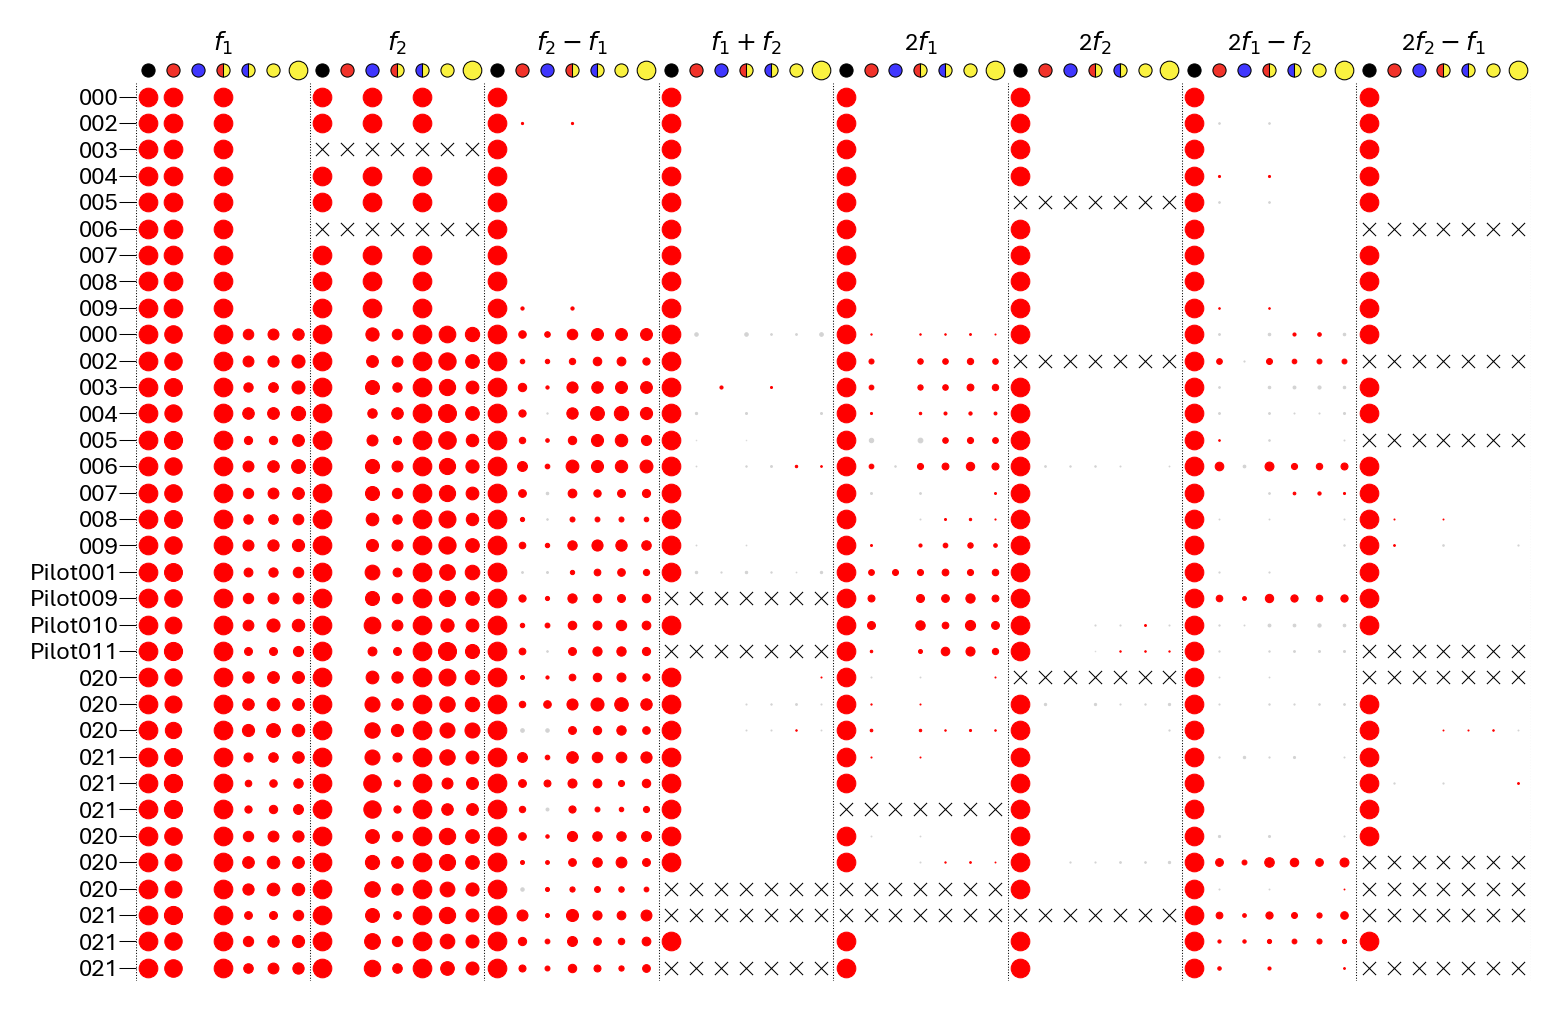

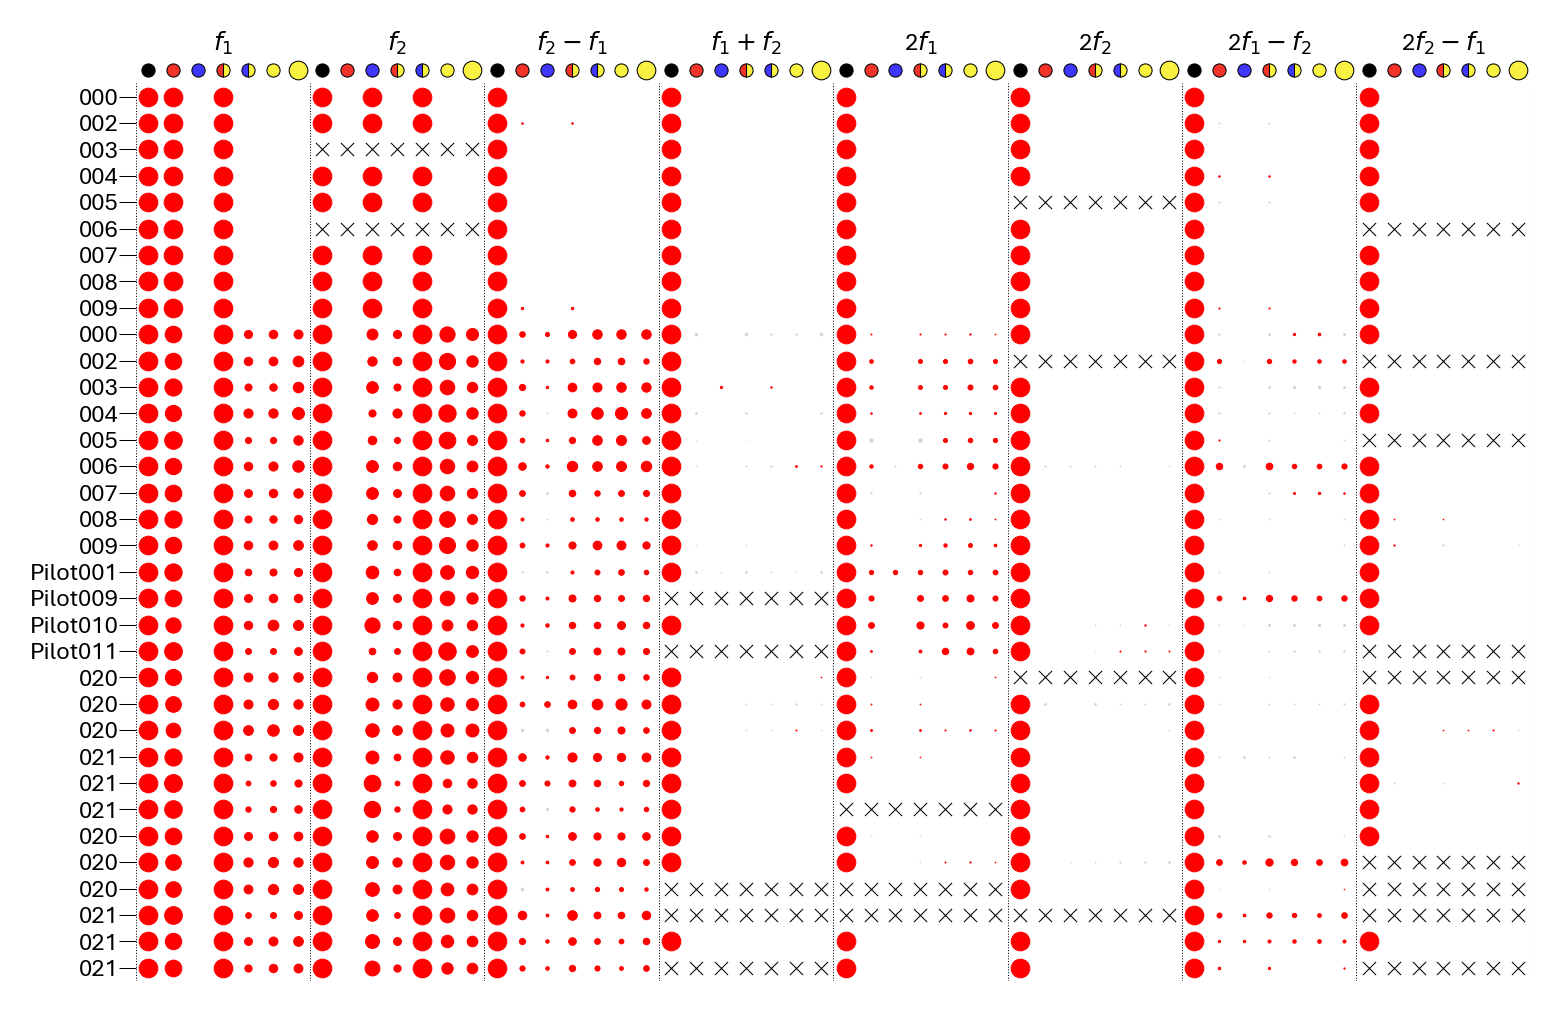

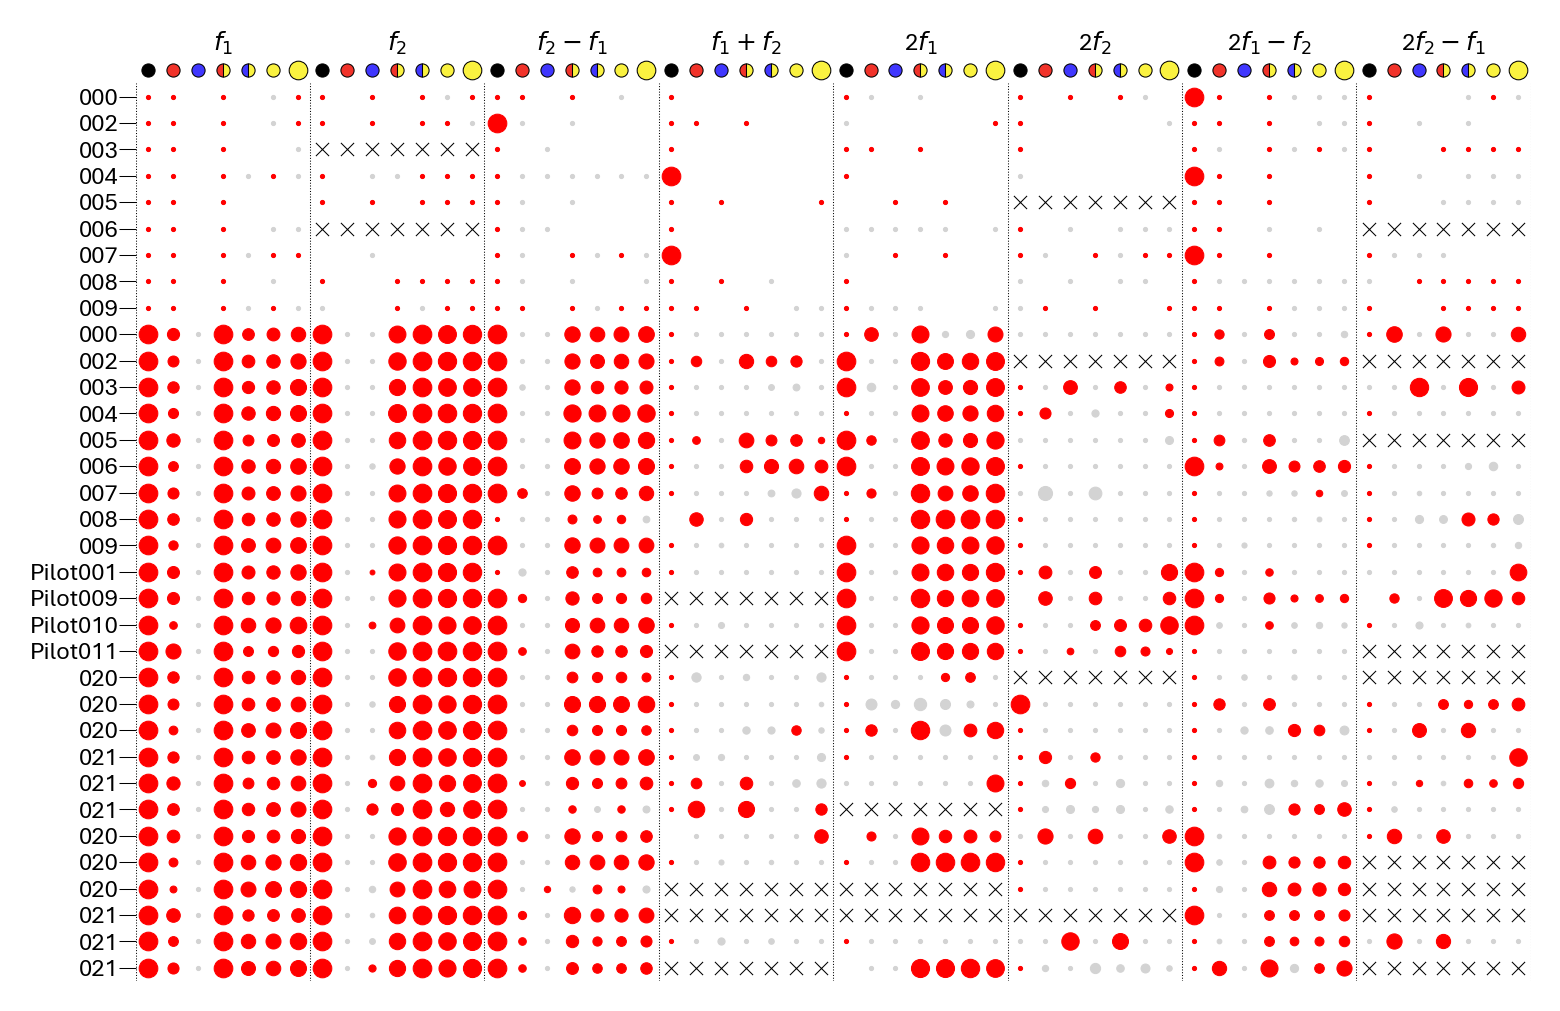

In [4]:
roi_types = [i for i in df.roi_map.unique()]
frequency_text_codes = get_frequency_text_codes()
roi_c_dict = get_roi_colour_codes()
from matplotlib.markers import MarkerStyle

def scale_value(x):
    proportion = (x - 0.5) / (1 - 0.5)
    scaled_value = proportion * (1 - 0.05) + 0.05
    return scaled_value

for metric_type in ["dice","jaccard","auc"]:

    for sub_ix, (experiment_id,sub_id,roi_task_id) in enumerate(zip(_experiment_ids,sub_ids, roi_task_ids)):
        columns = []
        row_metrics = []
        row_p_values = []
        for im_f_type, roi_type in itertools.product(im_strs, roi_types):
            _df = df[(df.experiment_id==experiment_id) & (df.sub_id==sub_id) & (df.roi_task_id==roi_task_id) & (df.metric_type==metric_type) & (df.im_map==im_f_type) & (df.roi_map==roi_type)]
            if _df.shape[0] == 0:
                f"Warning: No data loaded for [{experiment_id}, {sub_id}, {im_f_type}, {roi_type}] presumably due to no vertices in this case."
                columns.append((im_f_type, roi_type))  
                row_metrics.append(-1)
                row_p_values.append(-1)
            else:
                assert _df.shape[0] == 1, f"{_df.shape}"
                metric = _df.metric.values[0]
                p_value = _df.p_value.values[0]
                columns.append((im_f_type, roi_type))  
                row_metrics.append(metric)
                row_p_values.append(p_value)

        if sub_ix == 0:
            metrics = np.array(row_metrics)
            p_values = np.array(row_p_values)
        else:
            metrics = np.vstack((metrics, np.array(row_metrics)))
            p_values = np.vstack((p_values, np.array(row_p_values)))

    # Plot figure for each metric
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(6,4), dpi=300)
    empty_metrics = np.ma.array(np.zeros_like(metrics), mask=(np.zeros_like(metrics)==0))
    cmap = plt.get_cmap("binary")
    cmap.set_bad('white')
    im = ax.imshow(empty_metrics, cmap=cmap, interpolation='none', aspect='auto')
    pval_marker_s = 20
    for i in range(metrics.shape[0]):
        for j in range(metrics.shape[1]):
            _metric = metrics[i,j]
            _pval = p_values[i,j]
            # Plot ROIs that had no vertex allocated
            if _metric == -1 or np.isnan(_metric):
                ax.scatter(j+.5, i, s=10, marker='x',c='k',linewidths=.25)
                continue
            elif _metric < 0:
                print(f"WARNING: Skipping {j+.5}, {i}, a negative value detected: {_metric}.")
                continue
            # Marker color
            if _pval>1:
                raise ValueError()
            elif _pval < .05:
                c='red'
            else:
                c='lightgrey'
            # Marker size
            if metric_type == "auc":
                if _metric <= .5:
                    s = .05 * pval_marker_s
                else:
                    s = scale_value(_metric) * pval_marker_s
            else:
                s = _metric * pval_marker_s
            ax.scatter(j+.5,i,s=s,edgecolors=c,c=c,linewidths=.25)
    
    for i in ("top", "right", "bottom", "left"):
        ax.spines[i].set_visible(False)

    linewidth=.25
    ax.tick_params(axis="y", length=4, width=linewidth,pad=0)
    ax.set_yticks([i for i in range(len(sub_ids))])
    ax.set_yticklabels(sub_ids, fontsize=FONTSIZE)

    n_im_f_types = 8
    n_spatial_comparisons_per_im = metrics.shape[-1] / n_im_f_types

    xtick_pos = []
    xtick_labels = []
    for i in range(len(columns)):
        im_f_type, roi_type = columns[i]
        if roi_type == "IM":
            xtick_pos.append(i+n_spatial_comparisons_per_im/2)
            xtick_labels.append(frequency_text_codes[im_f_type])
    ax.set_xlim(min(xtick_pos)-.5, max(xtick_pos)+7.5)
    ax.set_xticks(xtick_pos)
    ax.set_xticklabels(xtick_labels, fontsize=FONTSIZE, rotation=0)
    ax.tick_params(axis="x", length=0, width=linewidth,pad=0, top=True, labeltop=True, labelbottom=False, bottom=False,rotation=0)

    x_boundary = 0
    for i in range(n_im_f_types):
        ax.plot([x_boundary,x_boundary],[ax.get_ylim()[0],ax.get_ylim()[-1]], c='k', linewidth=.25,linestyle='dotted')
        x_boundary += n_spatial_comparisons_per_im
        if i == n_im_f_types-1:
            ax.plot([x_boundary,x_boundary],[ax.get_ylim()[0],ax.get_ylim()[-1]], c='k', linewidth=.25,linestyle='dotted')

    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[-1]-1)
    ax.set_xlim(0,n_im_f_types*n_spatial_comparisons_per_im)

    pval_marker_s = 10
    for i in range(n_im_f_types):
        x_start = i * n_spatial_comparisons_per_im + .5
        y_pos = ax.get_ylim()[-1]+.5
        ax.scatter(x_start,y_pos, marker=MarkerStyle('o',fillstyle='full'),c="k", edgecolors='k',s=pval_marker_s, linewidths=.25)
        ax.scatter(x_start+1,y_pos, marker=MarkerStyle('o',fillstyle='full'),c=roi_c_dict["f1"], edgecolors='k',s=pval_marker_s, linewidths=.25)
        ax.scatter(x_start+2,y_pos, marker=MarkerStyle('o',fillstyle='full'),c=roi_c_dict["f2"], edgecolors='k',s=pval_marker_s, linewidths=.25)
        ax.scatter(x_start+3,y_pos, marker=MarkerStyle('o',fillstyle='left'),c=roi_c_dict["f1"], edgecolors='k',s=pval_marker_s, linewidths=.25)
        ax.scatter(x_start+3,y_pos, marker=MarkerStyle('o',fillstyle='right'),c=roi_c_dict["f1f2"], edgecolors='k',s=pval_marker_s, linewidths=.25)
        ax.scatter(x_start+4,y_pos, marker=MarkerStyle('o',fillstyle='left'),c=roi_c_dict["f2"], edgecolors='k',s=pval_marker_s, linewidths=.25)
        ax.scatter(x_start+4,y_pos, marker=MarkerStyle('o',fillstyle='right'),c=roi_c_dict["f1f2"], edgecolors='k',s=pval_marker_s, linewidths=.25)
        ax.scatter(x_start+5,y_pos, marker=MarkerStyle('o',fillstyle='full'),c=roi_c_dict["f1f2"], edgecolors='k',s=pval_marker_s, linewidths=.25)
        ax.scatter(x_start+6,y_pos, marker=MarkerStyle('o',fillstyle='full'),c=roi_c_dict["f1f2"], edgecolors='k',s=pval_marker_s*2, linewidths=.25)

In [19]:

df.roi_map.unique()

array(['IM', 'f1_only', 'f2_only', 'f1', 'f2', 'f1&f2', 'f1&f2_dil2mm'],
      dtype=object)

# $f_2$-$f_1$

In [123]:
metric_type = "jaccard"
im_code = "f2-f1"

Show overlap between $f_2$-$f_1$ and fundamental frequencies across all experiments

Text(0.5, 1.0, 'f2-f1')

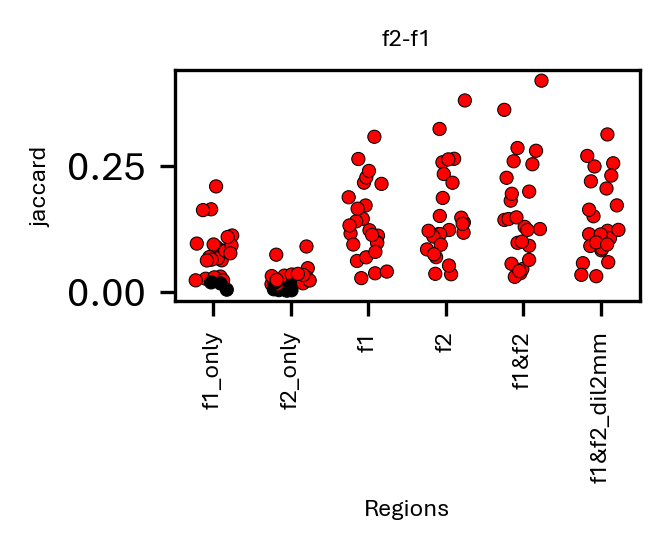

In [124]:
fig, ax = plt.subplots(figsize=(2,1), dpi=300)

xlabels = []
xticks = []
for xpos, roi_map in enumerate(df.roi_map.unique()):
    if roi_map == "IM":
        continue
    xlabels.append(roi_map)
    xticks.append(xpos)
    _metric = df[(df.metric_type==metric_type) & (df.im_map==im_code) & (df.roi_map==roi_map) & (~df.experiment_id.str.contains("Control"))].metric
    _pvalue = df[(df.metric_type==metric_type) & (df.im_map==im_code) & (df.roi_map==roi_map) & (~df.experiment_id.str.contains("Control"))].p_value
    _pvalue = ["r" if i < .05 else "k" for i in _pvalue]
    _xpos = np.zeros_like(_metric) + xpos
    _xjitter = np.zeros_like(_metric) + np.random.uniform(-.25,.25,_metric.shape[0])
    _xpos += _xjitter

    ax.scatter(_xpos, _metric, marker='o',c=_pvalue, edgecolors='k',s=10, linewidths=.25)

ax.set_xticks(xticks)
ax.set_xticklabels(xlabels,fontsize=FONTSIZE, rotation=90)
ax.set_xlabel("Regions",fontsize=FONTSIZE)
ax.set_ylabel(metric_type, fontsize=FONTSIZE)
ax.set_title(f"{im_code}", fontsize=FONTSIZE)

A lot of significance, but the metric (dice score) varies

Does multiplexed populations better explain $f_2$-$f_1$ areas?

- Compare multiplex to $f_1$ and $f_2$: 
    1. multiplex > all $f_1$,
    2. multiplex > all $f_2$
    3. multiplex > $f_1$ only
    4. multiplex > $f_2$ only
    
- Compare multiplex dilation:
    1. multiplex + 2mm dilation > multiplex

In [115]:
from scipy.stats import wilcoxon
import itertools

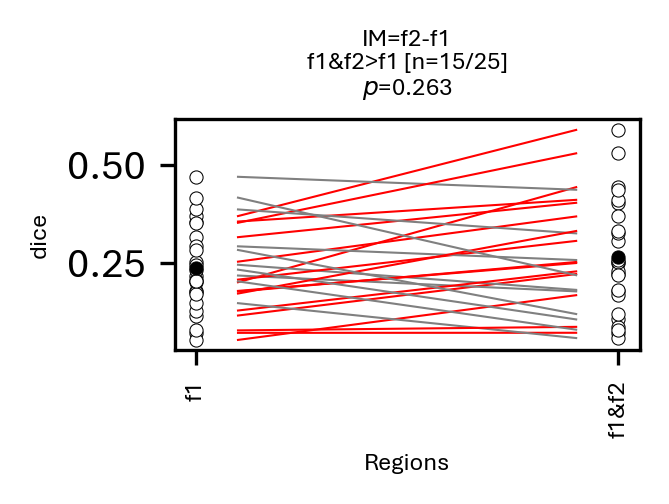

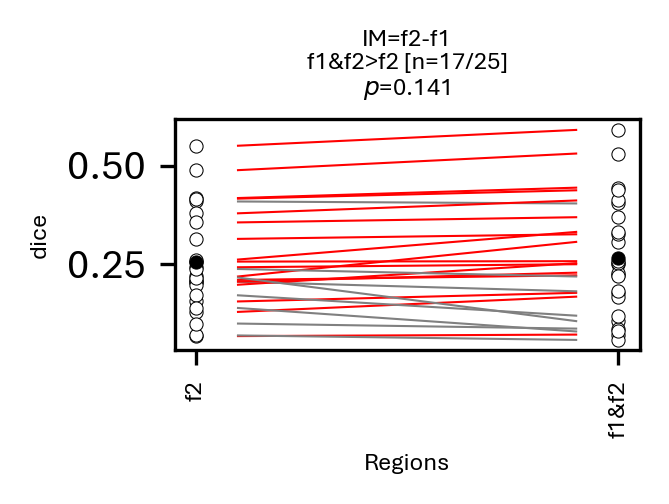

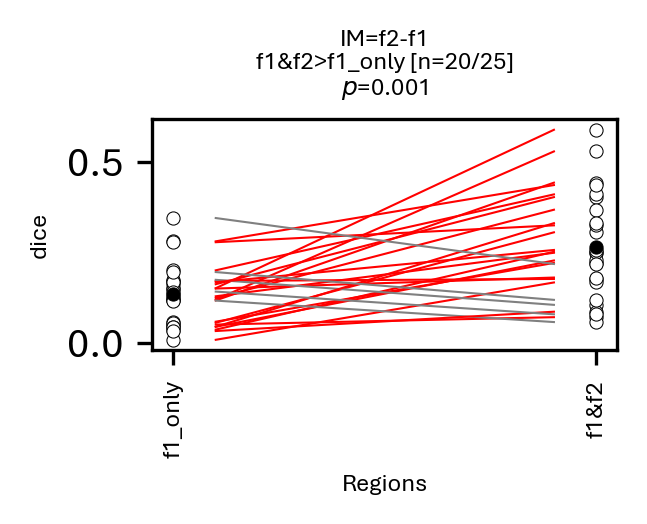

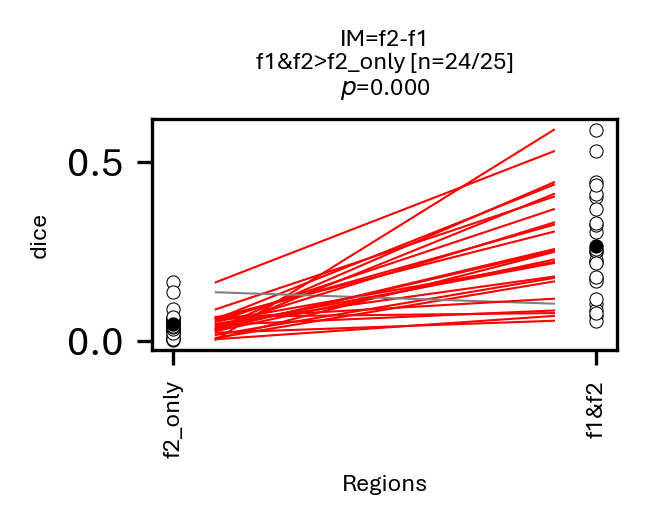

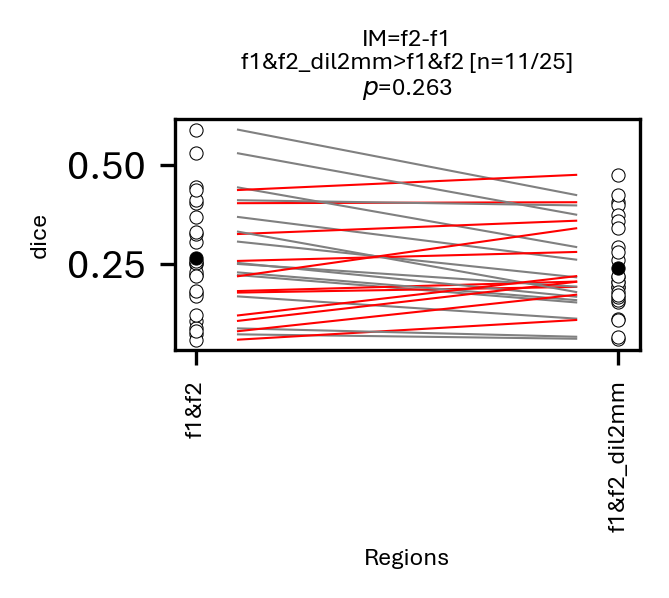

In [116]:
all_roi_maps = [
    ["f1","f1&f2"], #1
    ["f2","f1&f2"], #2
    ["f1_only","f1&f2"], #3
    ["f2_only","f1&f2"], #4
    ["f1&f2","f1&f2_dil2mm"], #5
]


for roi_maps in all_roi_maps:
    fig, ax = plt.subplots(figsize=(2,1), dpi=300)
    xlabels = []
    xticks = []
    # Scatter
    for xpos, roi_map in enumerate(roi_maps):
        if roi_map == "IM":
            continue
        xlabels.append(roi_map)
        xticks.append(xpos)
        _metric = df[(df.metric_type==metric_type) & (df.im_map==im_code) & (df.roi_map==roi_map) & (~df.experiment_id.str.contains("Control"))].metric
        _xpos = np.zeros_like(_metric) + xpos

        ax.scatter(_xpos, _metric, marker='o',c='white', edgecolors='k',s=10, linewidths=.25,zorder=1)
        ax.scatter(_xpos[0], _metric.mean(), marker='o',c='k', edgecolors='k',s=10, linewidths=.25,zorder=2)
    # Plot
    for (xpos_1, roi_map_1), (xpos_2, roi_map_2) in itertools.combinations(enumerate(roi_maps), 2):
        metric1 = df[(df.metric_type==metric_type) & (df.im_map==im_code) & (df.roi_map==roi_map_1) & (~df.experiment_id.str.contains("Control"))].metric
        metric2 = df[(df.metric_type==metric_type) & (df.im_map==im_code) & (df.roi_map==roi_map_2) & (~df.experiment_id.str.contains("Control"))].metric

        if xpos_1 < xpos_2:
            xpos_1 += .1
            xpos_2 -= .1
        else:
            xpos_1 -= .1
            xpos_2 += .1

        count = 0
        for _metric1, _metric2 in zip(metric1, metric2):
            c='grey'
            if _metric2 > _metric1:
                count+=1
                c='r'
            ax.plot([xpos_1, xpos_2], [_metric1, _metric2], color=c,linewidth=.5, linestyle='-')


    _wilc = wilcoxon(metric1, metric2)

    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels,fontsize=FONTSIZE, rotation=90)
    ax.set_xlabel("Regions",fontsize=FONTSIZE)
    ax.set_ylabel(metric_type, fontsize=FONTSIZE)
    ax.set_title(f"IM={im_code}\n{roi_map_2}>{roi_map_1} [n={count}/25]\n$p$={_wilc.pvalue:.3f}", fontsize=FONTSIZE,)